In [ ]:
!pip install timm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
"""defining transformations for data augmentation, setting up data loaders, creating a model using EfficientNetV2 architecture from timm, freezing some layers, defining loss function and optimizer, and then training the model.
 we are also tracking training progress with metrics like loss and accuracy. """
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import timm
import matplotlib.pyplot as plt
import tensorflow as tf

# path dataset
dataset_path = '/content/drive/MyDrive/dataset_split/'

# Assuming subdirectories for training and validation are directly inside the dataset directory
train_path = os.path.join(dataset_path, 'train')
val_path = os.path.join(dataset_path, 'val')

# Set device for model training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations with augmentation for training and validation sets
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prepare data loaders
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_path, transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Model setup
model = timm.create_model('tf_efficientnetv2_m.in21k_ft_in1k', pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, len(train_dataset.classes))
model = model.to(device)

model.trainable = False

  # Unfreeze some top layers for fine-tuning
# Example: Unfreeze the last N layers
N = 20
# Get the total number of layers in the model
total_layers = sum(1 for _ in model.parameters())

# Unfreeze the top N layers
num_layers_unfrozen = 0
for name, param in model.named_parameters():
    if num_layers_unfrozen < N:
        param.requires_grad = True
        num_layers_unfrozen += 1
    else:
        break

# Ensure the changes are applied to the model
model = model.to(device)

# Define the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
epochs=22

for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')


Epoch 1/22, Train Loss: 1.4079, Train Accuracy: 0.4658
Epoch 2/22, Train Loss: 1.3632, Train Accuracy: 0.5700
Epoch 3/22, Train Loss: 1.1881, Train Accuracy: 0.6156
Epoch 4/22, Train Loss: 1.0127, Train Accuracy: 0.6254
Epoch 5/22, Train Loss: 0.8639, Train Accuracy: 0.6938
Epoch 6/22, Train Loss: 0.8261, Train Accuracy: 0.7166
Epoch 7/22, Train Loss: 0.6706, Train Accuracy: 0.7883
Epoch 8/22, Train Loss: 0.8207, Train Accuracy: 0.7394
Epoch 9/22, Train Loss: 0.8165, Train Accuracy: 0.7068
Epoch 10/22, Train Loss: 0.6787, Train Accuracy: 0.7687
Epoch 11/22, Train Loss: 0.6589, Train Accuracy: 0.8306
Epoch 12/22, Train Loss: 0.6916, Train Accuracy: 0.7459
Epoch 13/22, Train Loss: 0.5317, Train Accuracy: 0.8371
Epoch 14/22, Train Loss: 0.6351, Train Accuracy: 0.8143
Epoch 15/22, Train Loss: 0.4948, Train Accuracy: 0.8469
Epoch 16/22, Train Loss: 0.6377, Train Accuracy: 0.8013
Epoch 17/22, Train Loss: 0.6617, Train Accuracy: 0.8176
Epoch 18/22, Train Loss: 0.6173, Train Accuracy: 0.8046
E

In [ ]:

# Validation
for epoch in range(epochs):
  model.eval()
  running_val_loss = 0.0
  correct_val = 0
  total_val = 0
  with torch.no_grad():
      for inputs, labels in val_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          val_loss = criterion(outputs, labels)
          running_val_loss += val_loss.item()

          _, predicted = torch.max(outputs.data, 1)
          total_val += labels.size(0)
          correct_val += (predicted == labels).sum().item()

  val_loss = running_val_loss / len(val_loader)
  val_accuracy = correct_val / total_val
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)

  print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')



Validation Loss: 0.7812, Validation Accuracy: 0.7059
Validation Loss: 0.7812, Validation Accuracy: 0.7059
Validation Loss: 0.7812, Validation Accuracy: 0.7059
Validation Loss: 0.7812, Validation Accuracy: 0.7059
Validation Loss: 0.7812, Validation Accuracy: 0.7059
Validation Loss: 0.7812, Validation Accuracy: 0.7059
Validation Loss: 0.7812, Validation Accuracy: 0.7059
Validation Loss: 0.7812, Validation Accuracy: 0.7059
Validation Loss: 0.7812, Validation Accuracy: 0.7059
Validation Loss: 0.7812, Validation Accuracy: 0.7059
Validation Loss: 0.7812, Validation Accuracy: 0.7059
Validation Loss: 0.7812, Validation Accuracy: 0.7059
Validation Loss: 0.7812, Validation Accuracy: 0.7059
Validation Loss: 0.7812, Validation Accuracy: 0.7059
Validation Loss: 0.7812, Validation Accuracy: 0.7059
Validation Loss: 0.7812, Validation Accuracy: 0.7059
Validation Loss: 0.7812, Validation Accuracy: 0.7059
Validation Loss: 0.7812, Validation Accuracy: 0.7059
Validation Loss: 0.7812, Validation Accuracy: 

In [ ]:
dataset_path = '/content/drive/MyDrive/dataset_split/'

# Assuming subdirectories for training and validation are directly inside the dataset directory
test_path = os.path.join(dataset_path, 'test')


# Prepare data loaders
test_dataset = datasets.ImageFolder(root=test_path, transform=train_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)


def evaluate_model(model, criterion, data_loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / len(data_loader)
    accuracy = correct / total
    print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')


evaluate_model(model, criterion, test_loader)


Loss: 0.9298, Accuracy: 0.7143


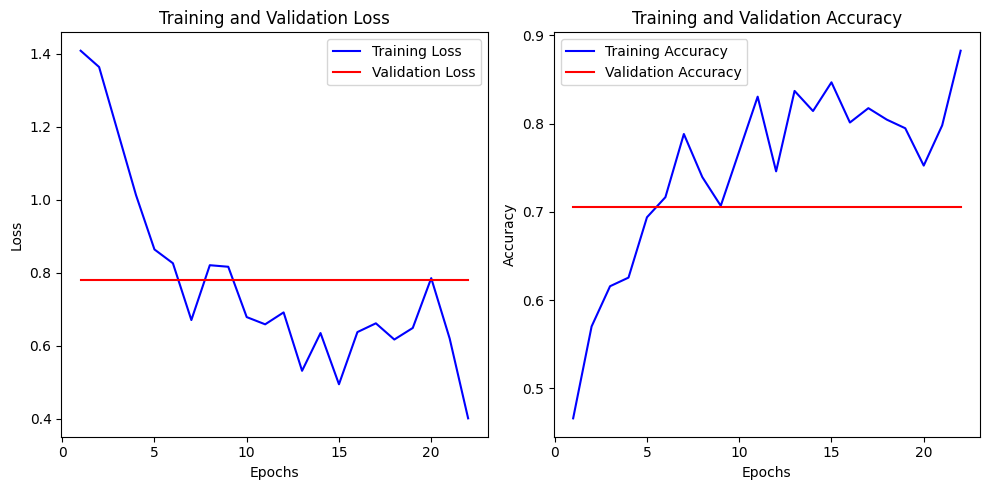

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, train_accuracies, val_losses=None, val_accuracies=None):
    epochs = range(1, len(train_losses) + 1)

    # Plotting training loss and accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training Loss')
    if val_losses:
        plt.plot(epochs, val_losses, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
    if val_accuracies:
        plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)
